In [3]:
!pip install nltk

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
import nltk
from nltk import word_tokenize
nltk.download('punkt_tab')
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/var/folders/79/22y9knc90290dd7t1yv0s_yc0000gn/T/ipykernel_9077/2892654812.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/islinashan/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
data_processed = pd.read_csv('tweets_preprocessed2_selected.csv')
non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=500)
suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=500)
balanced_data = pd.concat([non_suicide_data, suicide_data])

In [6]:
data_processed.head()
data_processed.shape

(10000, 6)

In [7]:
non_suicide_data.shape

(500, 6)

## Data Preprocessing

In [8]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1

In [9]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [10]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)
        
        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [11]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]

    
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)
        
    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [12]:
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Binary-Classfication LSTM

In [13]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))
        
        return outputs

In [14]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [15]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS GPU")
else:
    device = torch.device("cpu")
model = model.to(device)

Using MPS GPU


In [16]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [17]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    model.train()
    
    for batch in loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [18]:
def evaluate(model,loader,criterion): 
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)
            
            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [19]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):
    
    train_loss,train_acc = train(model,train_loader,optimizer,criterion)
    
    valid_loss,valid_acc = evaluate(model,test_loader,criterion)
    
    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)
    
    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.579 | Train Acc: 70.88%
	 Val. Loss: 0.651 |  Val. Acc: 58.17%



In [485]:
print("The best validation accuracy:", round(max(v_acc), 2))

The best validation accuracy: 0.83


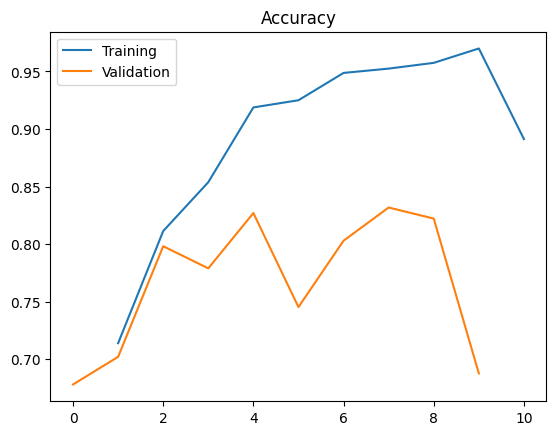

In [486]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

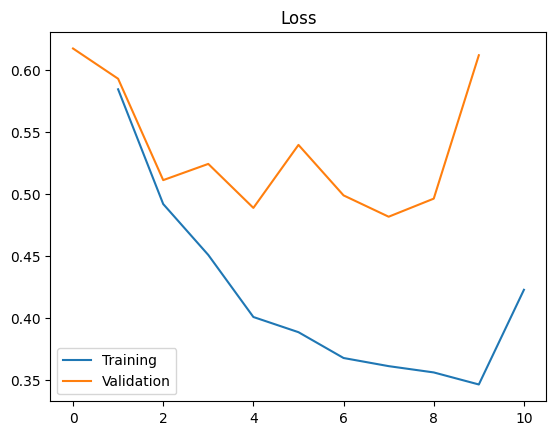

In [487]:
plt.plot(range(1, EPOCH_NUMBER+1), t_loss, v_loss)
plt.title("Loss")
plt.legend(("Training", "Validation"))

## Regression LSTM

In [16]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [17]:
regression = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.BCELoss()
optimizer = optim.Adam(regression.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
regression = regression.to(device)

In [18]:
def re_accuracy(preds, y, threshold=0.5):
    rounded_preds = (preds > threshold).float()  # Convert probabilities to binary predictions
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [19]:
def re_train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    model.train()
    
    for batch in loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].float().to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = re_accuracy(outputs, labels)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [20]:
def re_evaluate(model,loader,criterion): 
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].float().to(device)
            text_length = batch['text_length'].to(device)
            
            outputs = model(input_ids, text_length).squeeze(1)

            loss = criterion(outputs, labels)
            acc = re_accuracy(outputs, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [22]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):
    
    train_loss,train_acc = re_train(regression,train_loader,optimizer,criterion)
    
    valid_loss,valid_acc = re_evaluate(regression,test_loader,criterion)
    
    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)
    
    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

Epoch 1
	Train Loss: 0.671 | Train Acc: 66.88%
	 Val. Loss: 0.528 |  Val. Acc: 71.63%

Epoch 2
	Train Loss: 0.355 | Train Acc: 85.12%
	 Val. Loss: 0.849 |  Val. Acc: 59.62%

Epoch 3
	Train Loss: 0.254 | Train Acc: 89.38%
	 Val. Loss: 0.846 |  Val. Acc: 72.60%

Epoch 4
	Train Loss: 0.139 | Train Acc: 95.12%
	 Val. Loss: 0.861 |  Val. Acc: 69.23%

Epoch 5
	Train Loss: 0.107 | Train Acc: 96.25%
	 Val. Loss: 1.493 |  Val. Acc: 58.17%

Epoch 6
	Train Loss: 0.096 | Train Acc: 96.50%
	 Val. Loss: 0.826 |  Val. Acc: 74.52%

Epoch 7
	Train Loss: 0.062 | Train Acc: 98.12%
	 Val. Loss: 0.766 |  Val. Acc: 76.92%

Epoch 8
	Train Loss: 0.034 | Train Acc: 98.88%
	 Val. Loss: 0.832 |  Val. Acc: 76.92%

Epoch 9
	Train Loss: 0.028 | Train Acc: 99.00%
	 Val. Loss: 0.941 |  Val. Acc: 75.00%

Epoch 10
	Train Loss: 0.059 | Train Acc: 98.00%
	 Val. Loss: 0.959 |  Val. Acc: 76.44%



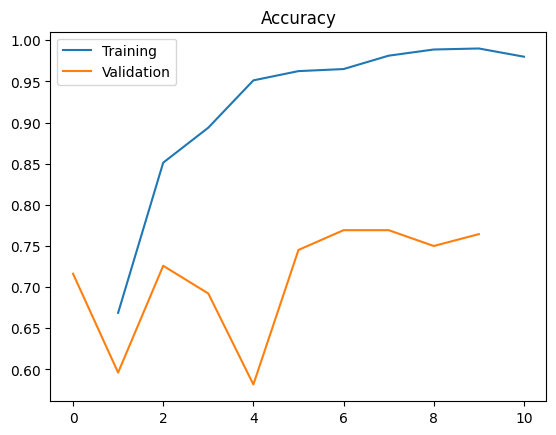

In [23]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

## LSTM with Attention Mechanism

To incorporate attention mechanism into the LSTM model, we compute attention weights over the LSTM output.

In [ ]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 1  # probability
n_layers = 2
bidirectional = True
dropout = 0.3

In [ ]:
import torch
import torch.nn as nn

class LSTMWithAttention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMWithAttention, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, 1)  # For attention weights
        self.softmax = nn.Softmax(dim=1)
        
        # Fully connected layers
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Use sigmoid as activation function for binary classification

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        # Attention mechanism
        attn_weights = self.attention(output)  # Shape: [batch_size, seq_len, 1]
        attn_weights = self.softmax(attn_weights.squeeze(-1))  # Shape: [batch_size, seq_len]
        
        # Context vector as weighted sum of outputs
        context = torch.bmm(attn_weights.unsqueeze(1), output).squeeze(1)  # Shape: [batch_size, hidden_dim * 2]
        
        # Concatenate final hidden state and context vector
        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)  # Final hidden state
        context_hidden = context + hidden  # Combine context and hidden state
        
        # Classification
        context_hidden = self.batch_norm(context_hidden)
        outputs = self.sigmoid(self.fc(self.dropout(context_hidden)))
        
        return outputs


In [ ]:
model = LSTMWithAttention(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS GPU")
else:
    device = torch.device("cpu")
model = model.to(device)

In [ ]:
EPOCH_NUMBER = 10
t_acc = []
t_loss = []
v_acc = []
v_loss = []

for epoch in range(1,EPOCH_NUMBER+1):
    
    train_loss,train_acc = train(model,train_loader,optimizer,criterion)
    
    valid_loss,valid_acc = evaluate(model,test_loader,criterion)
    
    t_acc.append(train_acc)
    t_loss.append(train_loss)
    v_acc.append(valid_acc)
    v_loss.append(valid_loss)
    
    print("Epoch", epoch)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print()

In [ ]:
plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
plt.title("Accuracy")
plt.legend(("Training", "Validation"))

## Inference

### Binary Classfication

In [488]:
def predict_sentence(sentence, model, word_map, device):
    # Preprocess the sentence
    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

    # Get the length of the input sentence (for packing sequence)
    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    # Perform inference
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    # Interpret the result
    if prediction == 0:
        return "The sentence is classified as Non-Suicidal."
    else:
        return "The sentence is classified as Suicidal."

In [489]:
sentence = "I feel hopeless."
result = predict_sentence(sentence, model, word_map, device)
print(result)

The sentence is classified as Suicidal.


### Regression

In [24]:
def regression_predict(sentence, model, word_map, device):

    encoded_sentence = text_encoder(sentence, word_map)
    input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)

    text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        output = model(input_tensor, text_length)  # Get the model output
        probability = torch.sigmoid(output).squeeze().item()  # Get the probability

    prediction = 1 if probability >= 0.5 else 0  # Threshold of 0.5
    if prediction == 0:
        result = f"The sentence is classified as Non-Suicidal with a probability of {1 - probability:.4f}."
    else:
        result = f"The sentence is classified as Suicidal with a probability of {probability:.4f}."

    return result

In [26]:
sentence = "I feel sad."
result = regression_predict(sentence, regression, word_map, device)
print(result)

The sentence is classified as Suicidal with a probability of 0.6399.
